In [1]:
# Install  libraries
!pip install pandas scikit-learn sentence-transformers joblib


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/275.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/275.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/275.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/275.9 kB 262.6 kB/s eta 0:00:01
   -------- ------------------------------ 61.4/275.9 kB 328.2 kB/s eta 0:00:01
   ------------- ------------------------- 92.2/275.9 kB 476.3 kB/s eta 0:00:01
   ------------------- ------------------ 143.4/275.9 kB 532.5 kB/s eta 0:00:01
   ----------------------- -------------- 174.1/275.9 kB 583.1 kB/s eta 0:00:01
   ---------------------------- --------- 204.8/275.9 kB 593.2 kB/s eta 0:00:01
   ------------------------------------ - 266.2/275.9 kB 682.7 kB/s eta 0:00:01
   -------------------------------------- 275.9/275.9 kB 654.3 kB/s eta 0:00:00


In [2]:
# Importing  libraries
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib


In [22]:
# Load fake and true news CSV files
fake_df = pd.read_csv('Fake.csv')  
true_df = pd.read_csv('True.csv')  

# Combine both datasets into one
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the dataset to mix fake and true news randomly
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display first few rows
df.head()


,title,text,subject,date,label,Unnamed: 4
0,Very Suspicious Smoke Is Billowing Out Of Clo...,During an uncharacteristically blistering hot ...,News,"September 1, 2017",1,NaN
1,Senate votes to begin tax bill negotiations wi...,WASHINGTON (Reuters) - The U.S. Senate voted o...,politicsNews,"December 6, 2017",0,NaN
2,The ‘Fake Melania Trump’ Conspiracy Theory Is...,"The Internet is going crazy after photos, vide...",News,"October 18, 2017",1,NaN
3,"Trumpcare Is Officially Dead, Senator Collins...","Graham-Cassidy, the latest and worst in a line...",News,"September 26, 2017",1,NaN
4,Former Trump adviser interviewed in Congress i...,"WASHINGTON (Reuters) - Walid Phares, a former ...",politicsNews,"December 8, 2017",0,NaN


In [23]:
# Keep only necessary columns
df = df[['title', 'text', 'label']]

# Combine 'title' and 'text' into 'content'
df['content'] = df['title'] + ' ' + df['text']

# Function to clean text
def clean_text(text):
    text = text.lower()                           # Lowercase the text
    text = re.sub(r'\W+', ' ', text)              # Remove special characters
    text = re.sub(r'\s+', ' ', text)              # Remove extra spaces
    return text.strip()

# Apply cleaning
df['content'] = df['content'].apply(clean_text)

# Drop rows with missing content or label
df.dropna(subset=['content', 'label'], inplace=True)

# Preview cleaned content
df['content'].head()


0    very suspicious smoke is billowing out of clos...
1    senate votes to begin tax bill negotiations wi...
2    the fake melania trump conspiracy theory is ta...
3    trumpcare is officially dead senator collins c...
4    former trump adviser interviewed in congress i...
Name: content, dtype: object

In [24]:
# Load the pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate semantic embeddings for each news content
embeddings = model.encode(df['content'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [7]:
# Separate features and labels
X = embeddings
y = df['label'].values

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Initialize and train the Logistic Regression classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)


In [9]:
# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.935
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93        89
           1       0.95      0.94      0.94       111

    accuracy                           0.94       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.94      0.94      0.94       200



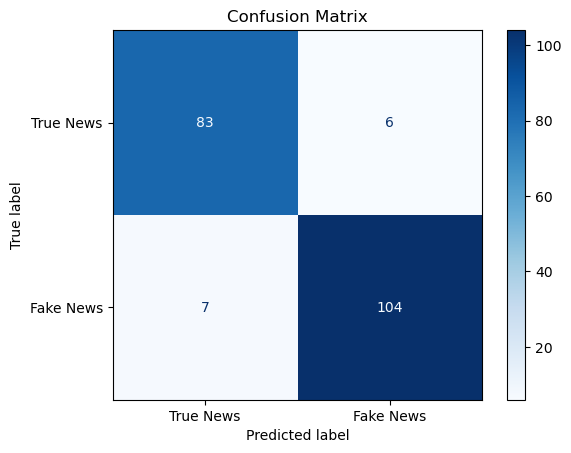

In [14]:
import matplotlib.pyplot as plt  

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True News', 'Fake News'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [31]:
# Save the classifier
joblib.dump(clf, 'fake_news_classifier.pkl')

# Save the sentence transformer model
model.save('sentence_transformer_model/', safe_serialization=False)

In [ ]:
#Load and Test 

In [32]:
# Load saved model 
clf = joblib.load('fake_news_classifier.pkl')
model = SentenceTransformer('sentence_transformer_model/')

# Example new news
new_text = "Breaking news: The economy is booming and stock markets are at an all-time high."

# Preprocess
cleaned_text = clean_text(new_text)

# Semantic embedding
new_embedding = model.encode([cleaned_text])

# Predict
prediction = clf.predict(new_embedding)

# Show result
print("Prediction:", "Fake" if prediction[0] == 1 else "True")


Prediction: Fake


In [33]:
import pandas as pd
import joblib
from sentence_transformers import SentenceTransformer
import re

# Load saved classifier and sentence transformer model
clf = joblib.load('fake_news_classifier.pkl')
model = SentenceTransformer('sentence_transformer_model/')

# Load the CSV file containing news
df_new = pd.read_csv('Fake.csv')   

# If the CSV has 'title' and 'text' columns, combine them
if 'title' in df_new.columns and 'text' in df_new.columns:
    df_new['content'] = df_new['title'] + ' ' + df_new['text']
elif 'content' not in df_new.columns:
    raise ValueError("CSV must contain 'content' or both 'title' and 'text' columns.")

# Clean the content (same cleaning function)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply cleaning
df_new['cleaned_content'] = df_new['content'].apply(clean_text)

# Generate semantic embeddings
embeddings = model.encode(df_new['cleaned_content'].tolist(), show_progress_bar=True)

#Predict using the classifier
predictions = clf.predict(embeddings)

# Add predictions to DataFrame
df_new['Prediction'] = ['Fake' if pred == 1 else 'True' for pred in predictions]

# Display results
print(df_new[['content', 'Prediction']])

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

                                               content Prediction
0     Donald Trump Sends Out Embarrassing New Year’...       Fake
1     Drunk Bragging Trump Staffer Started Russian ...       Fake
2     Sheriff David Clarke Becomes An Internet Joke...       Fake
3     Trump Is So Obsessed He Even Has Obama’s Name...       Fake
4     Pope Francis Just Called Out Donald Trump Dur...       Fake
..                                                 ...        ...
494   On The Day A Hurricane Is About To Hit Land, ...       Fake
495   RNC Staffer Assigned To Finding Positive Stor...       Fake
496   Trump Wants It Both Ways, But You Can’t Pass ...       Fake
497   REPORT: Mueller Hot On Trump’s Trail, Has Bui...       Fake
498   House Dem Wants GOP On Record: Stop Gov’t Spe...       True

[499 rows x 2 columns]



Classification Report:
              precision    recall  f1-score   support

        True       0.00      0.00      0.00         0
        Fake       1.00      0.95      0.97       499

    accuracy                           0.95       499
   macro avg       0.50      0.47      0.49       499
weighted avg       1.00      0.95      0.97       499



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


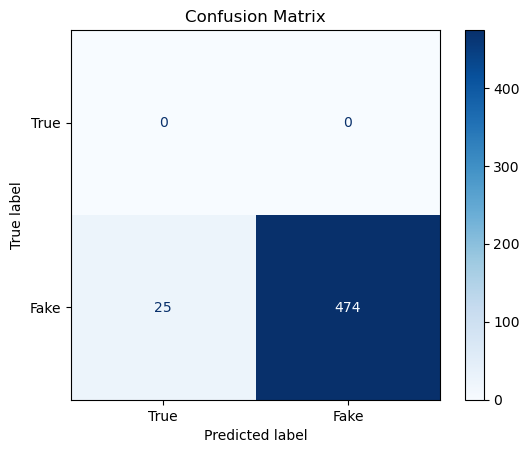

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure label column exists for evaluation
if 'label' in df_new.columns:
    print("\nClassification Report:")
    print(classification_report(df_new['label'], predictions, target_names=['True', 'Fake']))

    # Confusion Matrix
    cm = confusion_matrix(df_new['label'], predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['True', 'Fake'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("\nGround truth labels ('label' column) not found. Skipping evaluation metrics.")


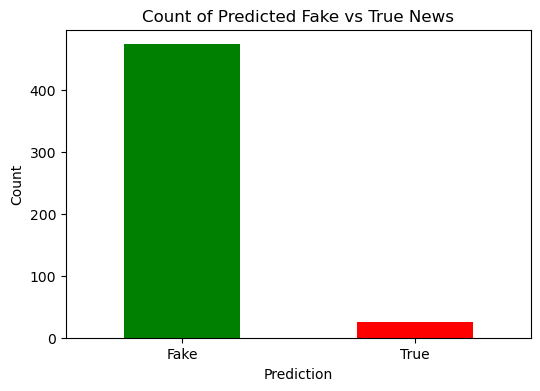

In [35]:
# Bar Chart of Predictions
prediction_counts = df_new['Prediction'].value_counts()

plt.figure(figsize=(6,4))
prediction_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Count of Predicted Fake vs True News')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
